# **Bitcoin Price Prediction Model**

## Executive Summary

In this project, I aimed to predict the closing price of Bitcoin (BTC) using historical price data and various technical indicators. I used a combination of Bitcoin, Ethereum (ETH), and S&P 500 futures data to build a robust predictive model. Initially, I experimented with linear regression and random forest models, iteratively improving the feature set and handling data preprocessing challenges. My final model, a Linear Regression with advanced feature engineering, demonstrated excellent performance with a Mean Squared Error (MSE) of 223,021.55 and an R-squared value of 0.9990. This project showcases the importance of feature selection, model evaluation, and iterative improvements in building predictive models for financial data.

## Introduction

This project aims to showcase a comprehensive set of data skills by developing an ETL (Extract, Transform, Load) pipeline combined with a predictive model for Bitcoin prices. This notebook will demonstrate proficiency in data extraction, transformation, loading, and machine learning, as well as data visualization techniques.

# Data Collection

### - Hourly historical S&P 500 futures data from Yahoo Finance API.
  
  S&P Futures were chosen after exploration of S&P 500 data showed a large difference in record counts compared to the BTC and ETH data. This was most likely due to the fact that S&P 500 is only traded within certain hours of the weekday, where futures are traded 24hrs a day more smililarly to crypto.
### - Hourly historical price data for Bitcoin and Ethereum from CoinAPI.
  
  Data for BTC and ETH was first pulled from Yahoo Finance as well, but upon exploration, the hourly data was found to be severely lacking in the 'Volume' column.


Fetch data from CoinAPI

In [ ]:
import requests
import pandas as pd
import datetime

# CoinAPI key
api_key = '0ED7563D-1876-4E4E-B897-DF5C8326B2EA'

# Function to fetch data from CoinAPI
def fetch_coinapi_data(symbol, period, limit):
    end_time = datetime.datetime.now().isoformat(timespec='seconds')
    start_time = (datetime.datetime.now() - datetime.timedelta(hours=limit)).isoformat(timespec='seconds')

    url = f"https://rest.coinapi.io/v1/ohlcv/{symbol}/history"
    params = {
        "period_id": period,
        "time_start": start_time,
        "time_end": end_time,
        "limit": limit
    }
    headers = {
        "X-CoinAPI-Key": api_key
    }
    response = requests.get(url, headers=headers, params=params)

    # Convert the response to JSON if it is not empty
    if response.status_code == 200 and response.text:
        data = response.json()
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['time_period_start'])
        df.set_index('Date', inplace=True)
        return df
    else:
        print(f"Failed to fetch data for {symbol}")
        return None

# Fetch the most recent 10000 hours of data for Bitcoin and Ethereum
btc_data = fetch_coinapi_data('BITSTAMP_SPOT_BTC_USD', '1HRS', 10000)
eth_data = fetch_coinapi_data('BITSTAMP_SPOT_ETH_USD', '1HRS', 10000)

# Print the first few rows to inspect
if btc_data is not None:
    print(btc_data.head())
if eth_data is not None:
    print(eth_data.head())


                                      time_period_start  \
Date                                                      
2023-11-16 08:00:00+00:00  2023-11-16T08:00:00.0000000Z   
2023-11-16 09:00:00+00:00  2023-11-16T09:00:00.0000000Z   
2023-11-16 10:00:00+00:00  2023-11-16T10:00:00.0000000Z   
2023-11-16 11:00:00+00:00  2023-11-16T11:00:00.0000000Z   
2023-11-16 12:00:00+00:00  2023-11-16T12:00:00.0000000Z   

                                        time_period_end  \
Date                                                      
2023-11-16 08:00:00+00:00  2023-11-16T09:00:00.0000000Z   
2023-11-16 09:00:00+00:00  2023-11-16T10:00:00.0000000Z   
2023-11-16 10:00:00+00:00  2023-11-16T11:00:00.0000000Z   
2023-11-16 11:00:00+00:00  2023-11-16T12:00:00.0000000Z   
2023-11-16 12:00:00+00:00  2023-11-16T13:00:00.0000000Z   

                                              time_open  \
Date                                                      
2023-11-16 08:00:00+00:00  2023-11-16T08:00:47.1760000

Fetch S&P futures from yahoo

In [ ]:
import yfinance as yf

# Fetch data for S&P 500 futures
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(hours=10000)
sp500_futures_data = yf.download('ES=F', start=start_date, end=end_date, interval='1h')
sp500_futures_data['Date'] = sp500_futures_data.index
sp500_futures_data.set_index('Date', inplace=True)


[*********************100%***********************]  1 of 1 completed


# Data Validation


Checking that the number of records from S&P Futures are not an intolerable discrepency with ETH and BTC record counts

In [ ]:
print(sp500_futures_data.shape)
print(btc_data.shape)
print(eth_data.shape)

(6444, 6)
(9976, 10)
(9975, 10)


# Transformation

Matching up data types and aligning indices

In [ ]:
# Ensure the indices are of datetime type
btc_data.index = pd.to_datetime(btc_data.index)
eth_data.index = pd.to_datetime(eth_data.index)
sp500_futures_data.index = pd.to_datetime(sp500_futures_data.index)

# Align the indices to match S&P 500 futures trading hours
btc_data_aligned = btc_data.reindex(sp500_futures_data.index, method='nearest')
eth_data_aligned = eth_data.reindex(sp500_futures_data.index, method='nearest')


Forward Fill missing values

In [ ]:

# Handle any remaining missing values
btc_data_aligned = btc_data_aligned.ffill()
eth_data_aligned = eth_data_aligned.ffill()
sp500_futures_data = sp500_futures_data.ffill()


Combine Dataframes

In [ ]:

# Combine the DataFrames by aligning indices
combined_data = pd.concat([
    btc_data_aligned[['price_close', 'price_high', 'price_low', 'volume_traded']].rename(columns={
        'price_close': 'BTC_Close',
        'price_high': 'BTC_High',
        'price_low': 'BTC_Low',
        'volume_traded': 'BTC_Volume'}),
    eth_data_aligned[['price_close', 'price_high', 'price_low', 'volume_traded']].rename(columns={
        'price_close': 'ETH_Close',
        'price_high': 'ETH_High',
        'price_low': 'ETH_Low',
        'volume_traded': 'ETH_Volume'}),
    sp500_futures_data[['Close', 'High', 'Low', 'Volume']].rename(columns={
        'Close': 'SP500_Futures_Close',
        'High': 'SP500_Futures_High',
        'Low': 'SP500_Futures_Low',
        'Volume': 'SP500_Futures_Volume'})
], axis=1)

# Save the combined dataframe to a CSV file
combined_data.to_csv('combined_data_hourly.csv', index=True)

# Print the first few rows to inspect
print(combined_data.head())

                           BTC_Close  BTC_High  BTC_Low  BTC_Volume  \
Date                                                                  
2023-11-16 12:00:00+00:00      37147   37324.0    37072   64.857563   
2023-11-16 13:00:00+00:00      36785   37172.0    36710  127.505302   
2023-11-16 14:00:00+00:00      36719   36871.0    36464  166.108019   
2023-11-16 15:00:00+00:00      36420   36913.0    36285  183.209044   
2023-11-16 16:00:00+00:00      36582   36647.0    36385  110.819406   

                           ETH_Close  ETH_High  ETH_Low   ETH_Volume  \
Date                                                                   
2023-11-16 12:00:00+00:00     2048.9    2070.0   2045.3   396.767760   
2023-11-16 13:00:00+00:00     2035.9    2052.7   2022.6   603.682115   
2023-11-16 14:00:00+00:00     2028.7    2040.3   2010.1   279.512469   
2023-11-16 15:00:00+00:00     1996.3    2034.9   1983.7   435.339755   
2023-11-16 16:00:00+00:00     2009.1    2012.1   1995.6  1240.220125  

# Exploratory Analysis

Observing summary statistics of the DataFrame.

In [ ]:
print(combined_data.describe())


           BTC_Close       BTC_High        BTC_Low   BTC_Volume    ETH_Close  \
count    6444.000000    6444.000000    6444.000000  6444.000000  6444.000000   
mean    63346.574333   63600.571443   63068.179702   105.471593  2949.335118   
std     15906.544586   15980.209705   15827.473607   119.101423   555.189477   
min     35758.000000   36056.000000   35539.000000     1.715202  1915.200000   
25%     55373.000000   55735.750000   54962.500000    32.716424  2441.600000   
50%     63278.000000   63549.500000   62984.500000    66.064730  2972.500000   
75%     68439.750000   68725.000000   68192.750000   132.996166  3425.200000   
max    108276.000000  108364.000000  107128.000000  1523.541942  4085.000000   

          ETH_High      ETH_Low   ETH_Volume  (SP500_Futures_Close, ES=F)  \
count  6444.000000  6444.000000  6444.000000                  6444.000000   
mean   2963.215419  2934.206704   335.434125                  5373.931331   
std     558.604308   551.615897   513.025826    

Exploring potential correlations with a heat map

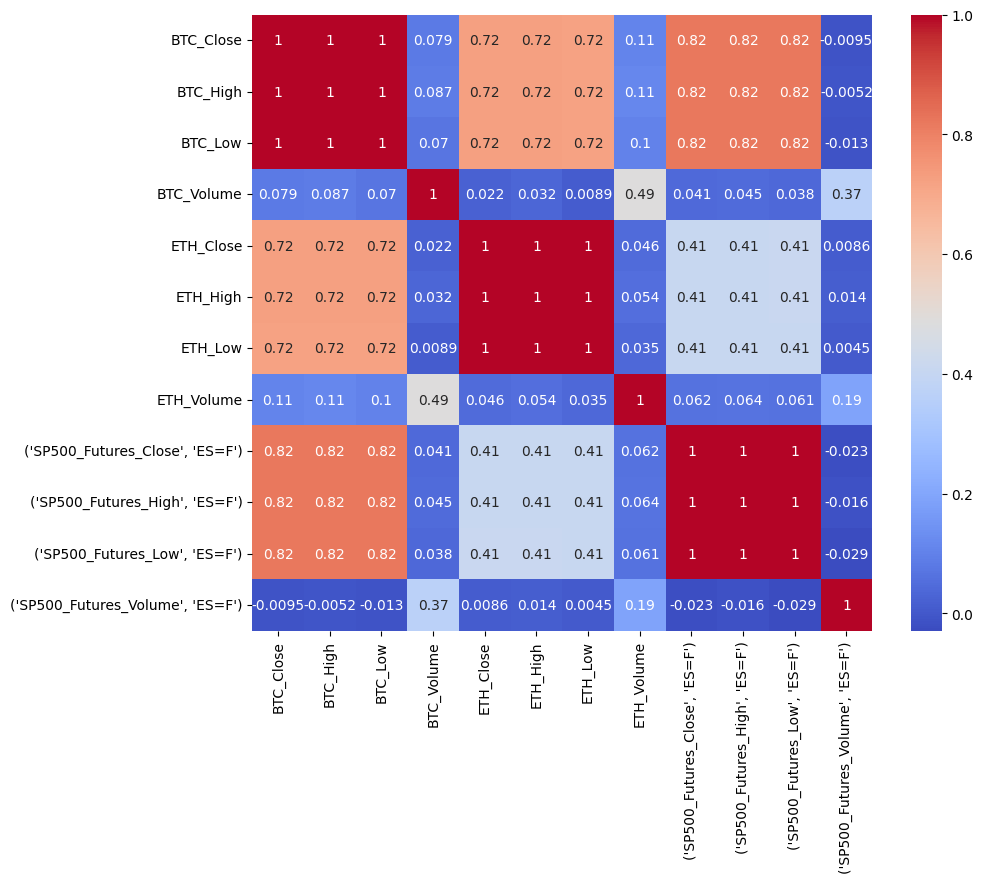

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(combined_data.corr(), annot=True, cmap='coolwarm')
plt.show()


# Feature Engineering

Starting with %Change as the only feature, a linear regression model was trained and tested. The performance of the model was abysmal, so moving averages and RSI were added to try and enhance the LR model to no avail. After moving on to the Random Forest Regressor, and it too was performing poorly, MACD and Bollinger Bands were added.

In [ ]:
# Feature Engineering

#% Change
combined_data['BTC_Return'] = combined_data['BTC_Close'].pct_change()
combined_data['ETH_Return'] = combined_data['ETH_Close'].pct_change()
combined_data[('SP500_Futures_Return', 'ES=F')] = combined_data[('SP500_Futures_Close', 'ES=F')].pct_change()

# Moving Averages
combined_data['BTC_MA_50'] = combined_data['BTC_Close'].rolling(window=50).mean()
combined_data['BTC_MA_200'] = combined_data['BTC_Close'].rolling(window=200).mean()
combined_data['ETH_MA_50'] = combined_data['ETH_Close'].rolling(window=50).mean()
combined_data['ETH_MA_200'] = combined_data['ETH_Close'].rolling(window=200).mean()
combined_data[('SP500_Futures_MA_50', 'ES=F')] = combined_data[('SP500_Futures_Close', 'ES=F')].rolling(window=50).mean()
combined_data[('SP500_Futures_MA_200', 'ES=F')] = combined_data[('SP500_Futures_Close', 'ES=F')].rolling(window=200).mean()

#RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
# Define RSI window period
rsi_window = 14
# Calculate RSI for Bitcoin
combined_data['BTC_RSI'] = calculate_rsi(combined_data['BTC_Close'], rsi_window)
# Calculate RSI for Ethereum
combined_data['ETH_RSI'] = calculate_rsi(combined_data['ETH_Close'], rsi_window)
# Calculate RSI for SP500 Futures
combined_data[('SP500_Futures_RSI', 'ES=F')] = calculate_rsi(combined_data[('SP500_Futures_Close', 'ES=F')], rsi_window)

#MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

# Calculate MACD for Bitcoin
combined_data['BTC_MACD'], combined_data['BTC_MACD_Signal'], combined_data['BTC_MACD_Histogram'] = calculate_macd(combined_data['BTC_Close'])

# Calculate MACD for Ethereum
combined_data['ETH_MACD'], combined_data['ETH_MACD_Signal'], combined_data['ETH_MACD_Histogram'] = calculate_macd(combined_data['ETH_Close'])

#Billinger Bands
def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return rolling_mean, upper_band, lower_band

# Calculate Bollinger Bands for Bitcoin
combined_data['BTC_Bollinger_Mean'], combined_data['BTC_Bollinger_Upper'], combined_data['BTC_Bollinger_Lower'] = calculate_bollinger_bands(combined_data['BTC_Close'])

# Calculate Bollinger Bands for Ethereum
combined_data['ETH_Bollinger_Mean'], combined_data['ETH_Bollinger_Upper'], combined_data['ETH_Bollinger_Lower'] = calculate_bollinger_bands(combined_data['ETH_Close'])

# Drop any remaining NaN values
combined_data.dropna(inplace=True)



Update Feature Set

In [ ]:
# Update the feature set
X = combined_data[['BTC_Return', 'ETH_Return', ('SP500_Futures_Return', 'ES=F'), 'BTC_RSI', 'ETH_RSI',
                   'BTC_MACD', 'BTC_MACD_Signal', 'BTC_MACD_Histogram',
                   'ETH_MACD', 'ETH_MACD_Signal', 'ETH_MACD_Histogram',
                   'BTC_Bollinger_Upper', 'BTC_Bollinger_Lower',
                   'ETH_Bollinger_Upper', 'ETH_Bollinger_Lower']]
X.columns = X.columns.map(str)  # Convert all column names to strings
y = combined_data['BTC_Close'].shift(-1).dropna()  # Predict the next closing price
X = X.iloc[:-1]  # Ensure X and y are aligned



Train-Test Split

In [ ]:

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Training and Testing Models

Linear Regression Model

On the first and second try with this model, it performed very poorly. With a Mean Squared Error of 238927889.03599638 and an R-squared of -0.008260571262653782, it basically wasn't predicting anything at all. However, after multiple round of adding features, the model finally made solid predictions against the test data.

In [ ]:
# Model Training
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)


Evaluate

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 223021.55455061022
R-squared: 0.999016261663081


Visualize

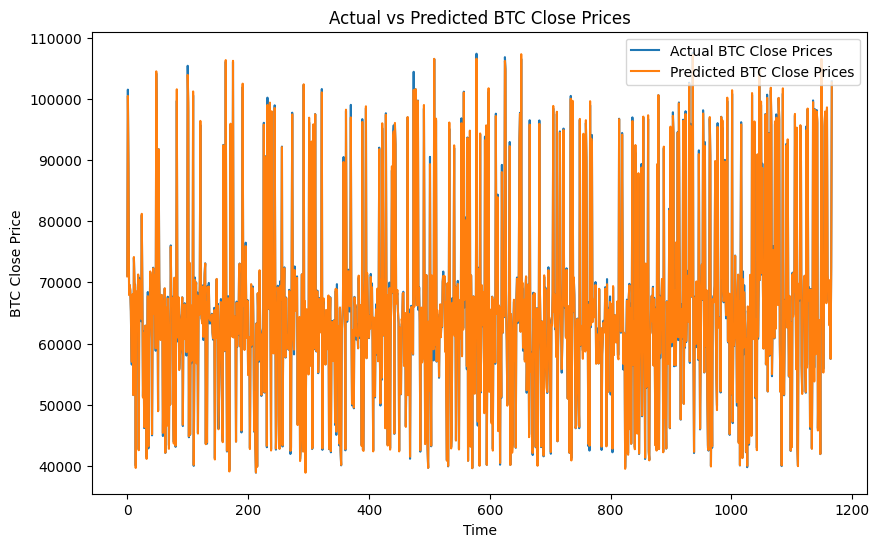

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual BTC Close Prices')
plt.plot(y_pred, label='Predicted BTC Close Prices')
plt.title('Actual vs Predicted BTC Close Prices')
plt.xlabel('Time')
plt.ylabel('BTC Close Price')
plt.legend()
plt.show()


Train Random Forest Regressor

Before the final round of technical indicators were added, I tried to fit the Random Forest Regressor model. Initially, this model also performed terribly. However, retraining the model on the last set of assed features did the trick.

In [ ]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:

# Train the Random Forest model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)






RandomForestRegressor(random_state=42)

Make Predictions

In [ ]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)




Evaluate

In [ ]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')


Random Forest Mean Squared Error: 264638.63658063416
Random Forest R-squared: 0.9988326905318237


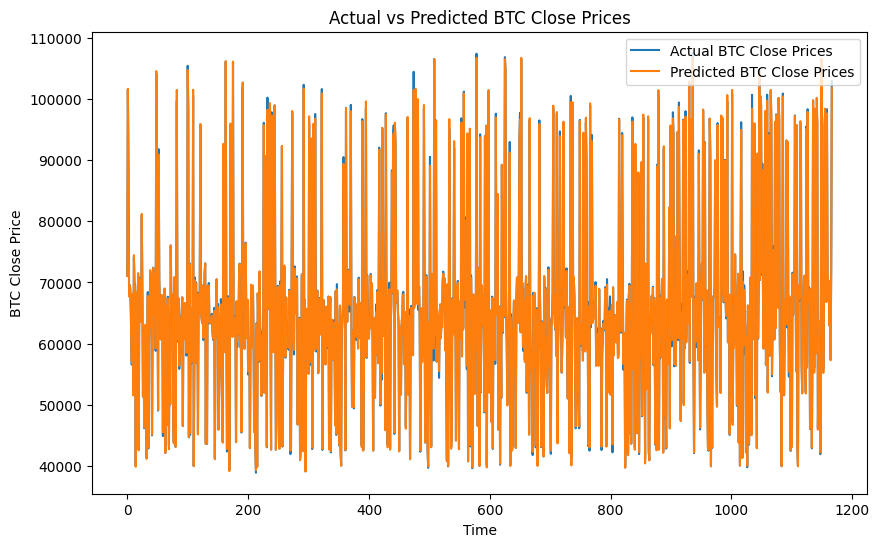

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual BTC Close Prices')
plt.plot(y_pred_rf, label='Predicted BTC Close Prices')
plt.title('Actual vs Predicted BTC Close Prices')
plt.xlabel('Time')
plt.ylabel('BTC Close Price')
plt.legend()
plt.show()


Model Interpretation

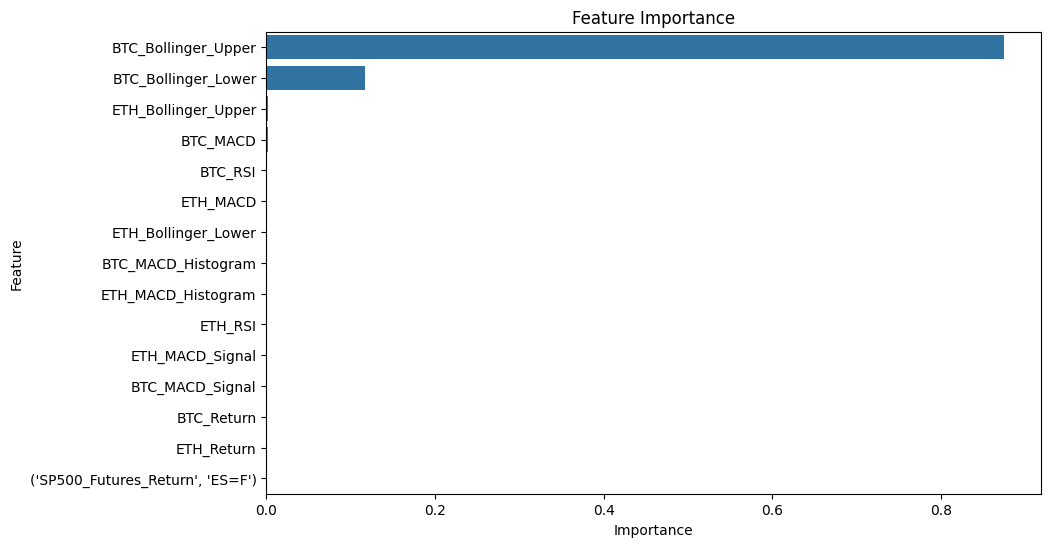

In [ ]:
#Feature Importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


Linear Regression

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print(feature_importance)


                             Feature   Coefficient
0                         BTC_Return  34552.401521
2   ('SP500_Futures_Return', 'ES=F')  14103.387796
1                         ETH_Return    413.871932
3                            BTC_RSI      3.605920
7                 BTC_MACD_Histogram      3.268223
5                           BTC_MACD      2.157951
9                    ETH_MACD_Signal      1.204516
8                           ETH_MACD      0.508224
12               BTC_Bollinger_Lower      0.502856
11               BTC_Bollinger_Upper      0.498816
14               ETH_Bollinger_Lower     -0.020063
13               ETH_Bollinger_Upper     -0.034910
10                ETH_MACD_Histogram     -0.696292
6                    BTC_MACD_Signal     -1.110270
4                            ETH_RSI     -1.433402


# Model Comparison

As we can see, the values for R squared and Mean squared error are slightly better with the standard linear regression model.

Saving LR model to a file

In [ ]:
import joblib

# Save the trained linear regression model to a file
joblib.dump(model, 'bitcoin_price_prediction_model.pkl')


['bitcoin_price_prediction_model.pkl']

In [ ]:
from google.colab import files

# Download the saved model file
files.download('/content/bitcoin_price_prediction_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>